<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Space-Homogeneous-Particle-Model" data-toc-modified-id="Space-Homogeneous-Particle-Model-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Space-Homogeneous Particle Model</a></span></li><li><span><a href="#Kinetic-Model" data-toc-modified-id="Kinetic-Model-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Kinetic Model</a></span></li><li><span><a href="#Running-and-Plotting" data-toc-modified-id="Running-and-Plotting-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Running and Plotting</a></span><ul class="toc-item"><li><span><a href="#Including-the-Kinetic-Model" data-toc-modified-id="Including-the-Kinetic-Model-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Including the Kinetic Model</a></span></li></ul></li><li><span><a href="#Invariant-Distribution-of-Particle-System" data-toc-modified-id="Invariant-Distribution-of-Particle-System-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Invariant Distribution of Particle System</a></span><ul class="toc-item"><li><span><a href="#Invariant-Measure-has-Mean-Zero" data-toc-modified-id="Invariant-Measure-has-Mean-Zero-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Invariant Measure has Mean Zero</a></span></li></ul></li><li><span><a href="#Change-of-Variables" data-toc-modified-id="Change-of-Variables-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Change of Variables</a></span></li></ul></div>

# Numerical Solution of Space-Homogeneous Model

<small> import modules hidden below </small>

In [2]:
import numpy as np
from numpy.random import normal, uniform

import scipy.stats as stats
from scipy.integrate import simps, solve_ivp

from pandas import DataFrame #For visualising arrays easily
import time
import warnings

import matplotlib.pyplot as plt
import matplotlib.animation as animation
import seaborn as sns
sns.set()
sns.color_palette('colorblind')

import plotting_tools as easyplt
import herding as herd


## Space-Homogeneous Particle Model 

In this section the space-homogeneous particle model is simulated. The model is
$\newcommand{\dif}{\mathrm{d}}$

\begin{align*}
  \dif V^{i,N}_t &= -V^{i,N}_t \dif t + G\left(\frac{1}{N}\sum_{j=1}^N V^{j,N}_t\right)\dif t + \sqrt{2\sigma} \dif W_t^i,
\end{align*}


The particle model is first simulated directly, calculating the interaction at every step. Dist cretise each SDE using the Euler-Maruyama scheme. Interaction functions ($G, \phi$) are defined in the separate `herding.py` file.

In [3]:
def run_particle_model(particles=100,
                   D=1,
                   initial_dist=uniform(size=100),
                   dt=0.01,
                   T_end=1,
                   G=herd.step_G):
    """ Space-Homogeneous Particle model
    
    Calculates the solution of the space-homogeneous particle model using an 
    Euler-Maruyama scheme.
    
    Args:
        particles: Number of particles to simulate, int.
        D: Diffusion coefficient denoted sigma in equation, float.
        initial_dist: Array containing initial velocities of particles.
        dt: Time step to be use in E-M scheme, float.
        T_end: Time point at which to end simulation, float.
        G: Interaction function - refer to herding.py.
        
    Returns:
        t: array of times at which velocities were calculated (only used for
           plotting).
        v: array containing velocities of each particle at every timestep.
    
    """
    steps = int(T_end/dt)
    v = np.zeros((steps+1, particle_count), dtype=float)
    #TODO: take density function as argument for initial data using inverse transform
    v[0, :] = initial_dist
    t = np.arange(0, T_end + dt, dt)
    
    for n in range(steps):
        v_curr = v[n, :]
        v[n+1, :] = (v_curr - v_curr*dt + G(herd.phi_part(v_curr))*dt 
                   + np.sqrt(2*D*dt) * normal(size=particles))

    return t, v


## Kinetic Model
The corresponding kinetic equation for the above particle system is

$$ \partial_t f_t(v) = - G(\langle w\rangle_{f_t})\partial_vf_t + \partial_v(vf_t) + \sigma\partial_{vv} f_t(v).$$


This can be solve numerically term by term. The time derivative will be approximated using a forward time FD scheme. The interaction term and the damping term will be approximated using an upwind scheme (either forward or backward depending on sign of advection term) while the diffusion will be approximated using a Crank-Nicholson scheme. 


In [4]:
def run_pde_model(D=1,
              initial_dist=(lambda x: np.array([int(i>=0 and i<=1) for i in x])),
              dt=0.01, T_end=1, L=5, dv=0.1, G=herd.step_G):
    """ Solves the kinetic model using standard FD schemes
    
    Uses standard finite-difference techniques to approximate the solution on
    [0,T_end] given an initial condition and prints mass loss.
    
    Args:
        D: Diffusion coefficient denoted sigma in equation, float.
        initial_dist: function describing initial density. 
        dt: Time step to be used, float.
        dv: Velocity step.
        T_end: Time point at which to end simulation, float.
        L: Velocity domain of solution. Choose to be large enough so that |v|
            never exceeds L.
        G: Interaction function - refer to herding.py.
    Returns:
        v: Velocity mesh on which solution was calculated, array.
        F: Approximate solution. Array is (time, space).
    
    Will warn if the initial density does not approximately integrate to 1.
    """
   
    v = np.arange(-L, L+dv, dv)
    t = np.arange(0, T_end+dt, dt)
    
    J = len(v)
    N = len(t)
    
    F = np.zeros((N, J), dtype=float) #array with rows in time, columns in space
    
    F_0 = initial_dist(v) #Initial Condition
    if not np.isclose(simps(F_0, dx=dv), 1, rtol=1e-05):
        warnings.warn('Normalising initial data...')
        F_0 = F_0/simps(F_0, dx=dv)
    F[0, :] = F_0
    F[0, :] = F_0
    
    
    F[:,0] = 0 #BCs 
    F[:,-1] = 0
    mu = 0.5 * D * dt/(dv**2)
    #TODO: Write Thomas Algorithm as a function.
    #Thomas Algorithm Coefficients
    a = mu
    b = 1 + 2*mu 
    c = mu
        
    d = np.zeros(J)
    e = np.zeros(J)
    f = np.zeros(J)
    
    # Build arrays of new coefficients
    for n in range(1, N):
        for j in range(1, J-1):
#TODO: check signs here - should increase accuracy
#             if np.sign(v[j]) <= 0: #Use backward upwind
#                 damp = (dt/dv) * (v[j] * F[n-1, j] - v[j-1] * F[n-1, j-1])
#             else: #Forward Upwind
#                 damp = (dt/dv) * (v[j+1] * F[n-1, j+1] - v[j] * F[n-1, j])
#             #Here they are the other way round as it is negative interaction in eq.
#             if np.sign(G(phi_pde(F[n-1,], v))) >= 0: #Forward upwind
#                 inter = G(phi_pde(F[n-1,], v))*(dt/dv) * (F[n-1, j+1] - F[n-1, j])
#             else: #Backward upwind
#                 inter = G(phi_pde(F[n-1,], v))*(dt/dv) * (F[n-1, j] - F[n-1, j-1])

            damp = (dt/dv) * (v[j] * F[n-1, j] - v[j-1] * F[n-1, j-1])
            inter = G(herd.phi_pde(F[n-1,], v))*(dt/dv) * (F[n-1, j] - F[n-1, j-1])
            diff = mu * (F[n-1, j+1] - 2*F[n-1, j] + F[n-1, j-1])

            d[j] = F[n-1, j] + damp + diff - inter
            e[j] = c/(b - a*e[j-1])
            f[j] = (d[j] + a*f[j-1]) / (b - a*e[j-1])
            
        for j in range(J-1, 0, -1):
            F[n, j-1] = f[j-1] + e[j-1]*F[n, j]
            
    mass_loss =  (1 - sum(F[-1,:])/sum(F[0,:]))*100
    print('Mass loss was {:.2f}%'.format(mass_loss))
    return v, F


In [5]:
T_end = 10
dt = 1
t = np.arange(0, T_end+dt, dt)
N = len(t)
print(N)

11


## Running and Plotting

First we illustrate how the particle system converges to a velocity distribution with mean $\pm 1$ using $G$ as 

$$G(u) = \frac{u+\text{sgn}(u)}{2}.$$

Setting the number of particles high enough makes a switch out of a metastable state very rare.

In [6]:
#Setting parameters
diffusion = 1
T_end = 10
timestep = 0.01
particle_count = 10**3
indicator = uniform(low=0, high=1, size=particle_count)

t_meta, traj_meta = run_particle_model(particles=particle_count, D=diffusion, 
                         initial_dist=indicator, dt=timestep,
                         T_end=T_end, G=herd.step_G)

One chart shows the velocity trajectories of 3 particles over the time interval. Second chart gives shows a histogram of the __entire__ time  note that if `T_end` is too small or the initial data very far from stationarity, this will not be a good estimate of a metastable position. Here we see convergence to a Gaussian distribution with mean 1 and variance 1.

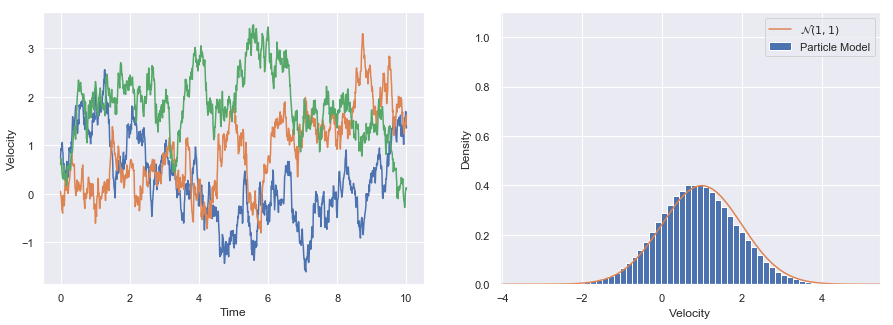

In [7]:
%matplotlib inline

fig, ax = plt.subplots(1,2, figsize=(15,5))
ax[0].plot(t_meta, traj_meta[:,0:3])
ax[0].set_xlabel('Time')
ax[0].set_ylabel('Velocity')


n, bins, patches = ax[1].hist(traj_meta.flatten(),
                              bins=np.arange(traj_meta.min(), traj_meta.max(), 0.15),
                              density=True, label='Particle Model')

ax[1].set_ylim(0,1.1)
ax[1].set_xlim(traj_meta.min(), traj_meta.max())
ax[1].set_xlabel('Velocity')
ax[1].set_ylabel('Density')

mu = np.sign(np.mean(traj_meta[0,:]))
sigma = np.sqrt(diffusion)

v = np.arange(mu - 5*sigma, mu + 5*sigma, 0.01)
ax[1].plot(v, stats.norm.pdf(v, mu, sigma),
           label=r'$\mathcal{N}(%g,%g)$'% (mu,sigma))
ax[1].legend()

plt.show()

For an idea of how we reach this metastable position, we can animate the histogram. Note here that the histogram is calculated __at each timestep__ not across all time. The animations will appear as a separate window. This makes saving them easier, and allows the notebook to continue running other cells.

In [21]:
%matplotlib qt

fig, ax = plt.subplots(1,1)
#plt.ion() #Interactive mode on


n, bins, patches = ax.hist(traj_meta[-1,:],
                           bins=np.arange(traj_meta.min(), traj_meta.max(), 0.15),
                           density=True, label='Particle Model')

ax.set_ylim(0,1.05)
ax.set_xlim(traj_meta.min(), traj_meta.max())

mu = np.sign(np.mean(traj_meta[0,:]))
sigma = np.sqrt(diffusion)

_v = np.arange(mu - 5*sigma, mu + 5*sigma, 0.01)
ax.plot(_v, stats.norm.pdf(_v, mu, sigma), label=r'Stationary D$^{\mathrm{n}}$')

fig.suptitle('t = {}'.format(t_meta[0]))
ax.legend()
ax.set_xlabel('Velocity')
ax.set_ylabel('Density')
 
def animate(i):
    n, _ = np.histogram(traj_meta[i,:],
                        bins=np.arange(traj_meta.min(), traj_meta.max(), 0.15),
                        density=True)  # update the data
    for rect, heig in zip(patches, n):
         rect.set_height(heig)
    fig.suptitle('t = {:.2f}'.format(t_meta[i]))

ani = animation.FuncAnimation(fig, animate, interval=50,
                              frames=T_end//timestep - 1)

fig.show()

### Including the Kinetic Model
The kinetic model is used in a very similar way to the particle model, other than `initial_dist` must be a __function__, rather than the array of velocities fed to the particle model. A plot containing the solution at the end time is shown. Again it can be seen that it converges to a Gaussian with mean $\pm 1$ depending on the initial data. 

In [6]:
D = 2
initial_dist = (lambda x: np.array([int(i>=0 and i<=1) for i in x]))
timestep = 0.01
T_end = 10
L = 10
dv = 0.1

v, sol = run_pde_model(D, initial_dist, timestep, T_end, L, dv, G=herd.smooth_G)

Mass loss was 0.00%


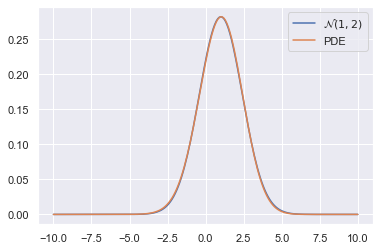

In [7]:
%matplotlib inline

initial = sol[0,]
mu = 1
plt.plot(v, stats.norm.pdf(v, mu, np.sqrt(D)), label=r'$\mathcal{N}(%s, %s)$'% (mu,D))
plt.plot(v, sol[-1,], label='PDE')
plt.legend()
plt.show()

We can now compare the solution from the kinetic model with that given by the particle model. We know that they agree in the limit as $N \to \infty$, so setting `particles` high should give good agreement. Below are also a few examples of possible initial distributions.

In [8]:
diffusion = 1
timestep = 0.01
T_end = 10
L = 5
dv= 0.1
particle_count = 10**4
############ Initial Distributions ############
#Indicator 
high_limit = 1
low_limit = 0

disc_indicator = uniform(low=low_limit, high=high_limit, size=particle_count)
cont_indicator = (lambda x: np.array([int(i >= low_limit and i <= high_limit) for i in x]))

#Gaussian 
cont_normal = lambda x: stats.norm.pdf(x, loc=0, scale=1)
disc_normal = normal(loc=0, scale=1, size=particle_count)

#Rough?
cont_rand = lambda x: uniform(low=0, high=1, size=len(x))

###############################################


v, sol = run_pde_model(D=diffusion, dt=timestep, T_end=T_end,
                   L=L, dv=dv, initial_dist=cont_indicator, G=herd.step_G)

t, traj = run_particle_model(particles=particle_count, D=diffusion,
                         initial_dist=disc_indicator, dt=timestep,
                         T_end=T_end, G=herd.step_G)

Mass loss was 0.12%


We will now start using `plotting_tools.py` to produce plots. This will help keep this workbook more focussed on the model, rather than becoming a tutorial on the intricacies of matplotlib.

Now we can produce an animation showing the convergence of the PDE and the particle model to the metastable state. Both models are in close agreement, so long as the number of particles is high enough to give a good density estimate.

In [1]:
%matplotlib notebook
ani = easyplt.animate_PDE_hist(t, v, traj, sol)
from IPython.display import HTML

NameError: name 'easyplt' is not defined

Animations can be saved as .MP4 files using the cell below. Quality is not as high as when ran directly from the notebook.

In [71]:
#Commented out so that it isn't ran by accident as it takes a while
#writer = animation.FFMpegWriter(fps = 20, extra_args=['-vcodec', 'libx264'])
#ani.save('spacehom.mp4', writer = writer)

For inline animation use the cell hidden below

In [ ]:
%matplotlib notebook
%matplotlib notebook
fig, ax= plt.subplots(figsize = (10,10))
L = 5
ax.set_ylim(sol.min(), sol.max()+0.1)
ax.set_xlim(-L, L)
ax.set_xlabel('Velocity')
ax.set_ylabel('Density')
fig.suptitle('t = {}'.format(t[0]))


plt.ion() #Interactive mode on
mu = np.sign(np.mean(traj[0,:]))
sigma = np.sqrt(diffusion)

#v = np.arange(mu - 5*sigma, mu + 5*sigma, 0.01)
ax.plot(v, stats.norm.pdf(v, mu, sigma), label = r'Stationary D$^{\mathrm{n}}$')

line, = plt.plot(v, sol[0,:], label = 'PDE')
n, bins, patches = plt.hist(traj[0,:],  bins=np.arange(traj.min(), traj.max(), 0.15), density = True, label= 'Particle Model')
ax.legend()
fig.show()
fig.canvas.draw()

for i in range(0, len(t)):
    line.set_ydata(sol[i,:])
    n, _ = np.histogram(traj[i,:],  bins = np.arange(traj.min(), traj.max(), 0.15), density = True)
    fig.suptitle('t = {:.2f}'.format(t[i]))
    for rect, heig in zip(patches, n):
         rect.set_height(heig)
    time.sleep(0.01)
    fig.canvas.draw()




## Invariant Distribution of Particle System

It has been mentioned that the particle system is converging to a _metastable_ state. It can be shown that the invariant measure for this system has mean zero, not $\pm 1$ as our simulations would suggest. This is because of the noise inherent in the system. The particles are able to 'jump' out of the potential well in which they lay. If enough particles perform this jump at the same time, they will begin to have a noticeable effect on the other particles until a switch in stability occurs. In this section it will be shown that the invariant measure has mean zero, as well as some explicit forms of the invariant distribution for specific herding functions $G$. The phenomena will then be illustrated numerically using a small number of particles. Doing so allows each particle to exert more influence on the system as a whole, making jumps more common. Changing the potential well that the particles lie in will also be investigated.

### Invariant Measure has Mean Zero
Consider the space-homogeneous particle model as given at the top of the page. 

$$
\dif v^{i,N}_t = -v^{i,N}_t \dif t + G\left(\frac{1}{N}\sum_{j=1}^N v^{j,N}_t\right)\dif t + \sqrt{2\sigma} \dif W_t^i
$$

Let $m_t = \frac{1}{N}\sum_{j=1}^N V^{j,N}_t$. Summing the system across $i$ gives an equation for $m_t$:

$$
    \dif m_t = \lbrack -m_t + G(m_t)\rbrack \dif t +\sqrt{2\sigma}\dif W_t
$$

Let $V(x) = \frac{x^2}{2} + \tilde{V}(x)$, where $-\tilde{V}'(x) = G(x)$ so that $-V'(x) = -x + G(x)$. The aim here is to find a function $V$ such that the equation for $m_t$ resembles the Langevin equation. The existence and uniqueness of the invariant measure will then follow from standard theory for the Langevin equation. Thus

\begin{equation}
    \dif m_t = -V'(m_t)\dif t + \sqrt{2\sigma}\dif W_t.\label{eq:meanSDE}
\end{equation}

By definition, $\tilde{V}(x) = - \int_{-\infty}^x G(u) \dif u$. As $G$ is bounded, $\tilde{V}(x)$ grows at most linearly. This means $V(x) \to \infty$ as$|x|\to \infty$, $V$ is a well-defined potential well and $\mathrm{e}^{-V(x)}$ is integrable. Hence \eqref{eq:meanSDE} admits a unique invariant measure, $\rho(x) = Z^{-1}\mathrm{e}^{-V(x)}$ with $Z$ a normalising constant.

What can we say about this invariant measure? Recall the only restrictions placed on $G$ were:
- $G$ must be odd, that is $G(u)=-G(-u)$
- $$
    \begin{cases}
         G(u)>u & \text{if } 0<u<1\\ 
         G(u)<u &  \text{if } u>1
    \end{cases}
  $$
  
If $G$ is odd, $\tilde{V}(x)$ is an even function, so $V(x)$ is also an even function. Then the mean of the invariant distribution $\rho$ is
#TODO this notation is wrong. 
$$\mathbb{E}[m_t] \to \int_{\mathbb{R}} m \text{e}^{-V(m)}\dif m = 0, $$
as this is the integral of an odd function.
***
This shows that the simulation is not telling the whole story of the particle system - it should be converging to a distribution with mean zero!


In [ ]:
#Long run of low particle number, time average hist

%matplotlib qt
diffusion = 1
timestep = 0.01
T_end = 10**5
L = 5
dv= 0.1
particle_count = 4
disc_indicator = uniform(low=-0.5, high=0.5, size=particle_count)

t, traj = run_particle_model(particles=particle_count, D=diffusion,
                         initial_dist=disc_indicator, dt=timestep,
                         T_end=T_end, G=herd.step_G)

In [73]:
fig, ax = plt.subplots(1,1)
#plt.ion() #Interactive mode on


n, bins, patches = ax.hist(traj.flatten(),
                           bins=np.arange(traj.min(), traj.max(), 0.15),
                           density=True, label='Particle Model')

ax.set_ylim(0,1.05)
ax.set_xlim(traj.min(), traj.max())

mu = np.sign(np.mean(traj[0,:]))
sigma = np.sqrt(diffusion)

_v = np.arange(mu - 5*sigma, mu + 5*sigma, 0.01)
ax.plot(_v, stats.norm.pdf(_v, mu, sigma), label=r'Stationary D$^{\mathrm{n}}$')

fig.suptitle('t = {}'.format(t[0]))
ax.legend()
ax.set_xlabel('Velocity')
ax.set_ylabel('Density')

fig.show()

## Change of Variables 
Here we look at the change of variables (2.3), instead of simulating the full system. Start with simulating the Fokker-Planck eq. for the OU process. Then estimate the integral and change variables. 

In [12]:
diffusion = 1
timestep = 0.01
T_end = 10
L = 8
dv= 0.1
v, ou_sol = run_pde_model(D=diffusion, dt=timestep, T_end=T_end,
                   L=L, dv=dv, initial_dist=cont_indicator, G=herd.no_G)

Mass loss was 0.00%


Aim: Calculate 

$$ \int_0^t G(M_1(s))\dif s   $$

Do this by solving the ODE:
$$ \dot{M}_1(s) = G(M_1(s))-M_1(s)$$

- Use ODE solver
- Solve by hand?


In [ ]:
M_dot = lambda t, G, M: G(M) - M

T_end=100
t = np.arange(0,T_end+dt,dt)
M = solve_ivp(fun = lambda t,M : M_dot(t,step_G,M), t_span = [0,T_end], y0=[-0.5], t_eval=t)
M = M.y.flatten()
print(M[-1])
integ=np.zeros(len(t))
for i in range(1,len(t)):
    integ[i] = simps(M[0:i], dx = dt)

plt.plot(t,integ)
plt.show()


In [ ]:
%matplotlib inline
plt.plot(v, ou_sol[-1,:], label = 'PDE')
#print(np.mean(sol[0,:]))
mu = 0
plt.plot(v, stats.norm.pdf(v, mu, sigma), label = r'Stationary D$^{\mathrm{n}}$')
plt.legend()
plt.show()